In [4]:
import pandas as pd
import pandas_datareader as dr
from datetime import datetime
import pandas_datareader.data as web

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from scipy import misc
import glob


In [5]:
start=datetime(2015,1,1)
end=datetime(2019,4,1)

In [6]:
# tesla = web.DataReader('TSLA', 'google', start,end)
microsoft = dr.data.get_data_yahoo('MSFT', start=start, end=end)

dataset = microsoft
close_data = microsoft['Close']
dates = pd.DataFrame(close_data.index)

dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,42.418739
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,42.028660
2015-01-06,46.750000,45.540001,46.380001,45.650002,36447900.0,41.411785
2015-01-07,46.459999,45.490002,45.980000,46.230000,29114100.0,41.937946
2015-01-08,47.750000,46.720001,46.750000,47.590000,29645200.0,43.171677


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
 > 3.881
 > 1.896
 > 3.296
 > 2.073
 > 2.614
 > 1.844
 > 4.332
 > 2.919
 > 1.735
 > 4.479
 > 3.818
 > 5.129
 > 2.947
 > 3.287
 > 2.452
 > 3.417
 > 2.415
 > 2.880
 > 1.752
 > 1.621
 > 1.922
 > 1.666
 > 2.016
 > 3.090
 > 3.440
 > 2.891
 > 3.700
 > 2.492
 > 2.011
 > 3.422
cnn: 2.848 RMSE (+/- 0.911)


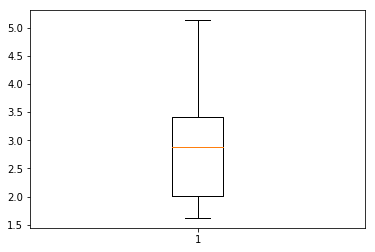

In [7]:
# evaluate cnn
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

series = dataset['Close']
data = series.values
# data split
n_test = 12
# define config
config = [36, 256, 3, 100, 100]
#n_input, n_filters, n_kernel, n_epochs, n_batch

# grid search
scores = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('cnn', scores)